# Final Project
### Team: Data Miner(Weirong He, Michael Gainey, Tri Pham)
### Topic: Taxi Data Analysis

### Introduction
This project is an analysis of taxi trips in New York City during the year of 2020. We selected the first week of each month due to the large size of the dataset. We wanted to see what hours of the day are the busiest along with which location has the most activity. We intended for this to help taxi drivers and passengers figure when and where to catch a cab. For drivers, we wanted to find the most profitable areas, and for passengers we wanted to figure out what the average fare amount would be for a given time. 

### Infrastructure analysis
We’re using pyspark, numpy,  pandas,  matplotlib,  geopandas, pyarrow, and sklearn. Pyspark is used so that we can quickly load and work with data since it would take too long doing it the conventional way. Numpy, pandas, and pyarrow were used to manipulate the datas while matplotlib and geopandas were for making visualizations. Sklearn is our machine learning module. The project should be able to be used as an application if the dataset was the same format. Our project should be able to scale well in terms of data processing, we ran it without limiting ourselves to the first week successfully. However some of our visualizations such as the heat map and the scatter points would be harder to read due to the amount of data showing, specifically the scatter points.

In [1]:
# Spark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# draw map
import geopandas as gpd
# quickly toPandas
import pyarrow.parquet as pq
# GUI
import ipywidgets as widgets
# Machine Learning
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# save trained model
import joblib

In [2]:
sc = SparkContext()
session = SparkSession(sc)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/17 02:40:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Process
This data set could be download at https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In this project, we are focusing on the year 2020, so we have 12 months of taxi data to go through. However, this dataset is too large for this project, it consists of about 25 million records. So we sampled the data and decided to only take data from the first week of each month which resulted in around 5M records.


In [3]:
taxi_record_1 = session.read.csv("data/records/yellow_tripdata_2020-01.csv", header=True)
taxi_record_2 = session.read.csv("data/records/yellow_tripdata_2020-02.csv", header=True)
taxi_record_3 = session.read.csv("data/records/yellow_tripdata_2020-03.csv", header=True)
taxi_record_4 = session.read.csv("data/records/yellow_tripdata_2020-04.csv", header=True)
taxi_record_5 = session.read.csv("data/records/yellow_tripdata_2020-05.csv", header=True)
taxi_record_6 = session.read.csv("data/records/yellow_tripdata_2020-06.csv", header=True)
taxi_record_7 = session.read.csv("data/records/yellow_tripdata_2020-07.csv", header=True)
taxi_record_8 = session.read.csv("data/records/yellow_tripdata_2020-08.csv", header=True)
taxi_record_9 = session.read.csv("data/records/yellow_tripdata_2020-09.csv", header=True)
taxi_record_10 = session.read.csv("data/records/yellow_tripdata_2020-10.csv", header=True)
taxi_record_11 = session.read.csv("data/records/yellow_tripdata_2020-11.csv", header=True)
taxi_record_12 = session.read.csv("data/records/yellow_tripdata_2020-12.csv", header=True)
location_df = pd.read_csv("data/taxi+_zone_lookup.csv")

In [4]:
dates = ("2020-01-01",  "2020-01-07")
taxi_record_1 = taxi_record_1.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-02-01",  "2020-02-07")
taxi_record_2 = taxi_record_2.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-03-01",  "2020-03-07")
taxi_record_3 = taxi_record_3.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-04-01",  "2020-04-07")
taxi_record_4 = taxi_record_4.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-05-01",  "2020-05-07")
taxi_record_5 = taxi_record_5.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-06-01",  "2020-06-07")
taxi_record_6 = taxi_record_6.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-07-01",  "2020-07-07")
taxi_record_7 = taxi_record_7.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-08-01",  "2020-08-07")
taxi_record_8 = taxi_record_8.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-09-01",  "2020-09-07")
taxi_record_9 = taxi_record_9.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-10-01",  "2020-10-07")
taxi_record_10 = taxi_record_10.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-11-01",  "2020-11-07")
taxi_record_11 = taxi_record_11.where(F.col('tpep_pickup_datetime').between(*dates))
dates = ("2020-12-01",  "2020-12-07")
taxi_record_12 = taxi_record_12.where(F.col('tpep_pickup_datetime').between(*dates))

In [5]:
taxi_record = (taxi_record_1.union(taxi_record_2).union(taxi_record_3)
               .union(taxi_record_4).union(taxi_record_5).union(taxi_record_6)
               .union(taxi_record_7).union(taxi_record_8).union(taxi_record_9)
               .union(taxi_record_10).union(taxi_record_11).union(taxi_record_12)
               .drop("VendorID", "RatecodeID", "passenger_count", "payment_type", "store_and_fwd_flag",
                     "improvement_surcharge", "mta_tax", "tolls_amount", "congestion_surcharge")
              )
taxi_record = (taxi_record.withColumn('trip_distance', F.col("trip_distance").cast("float"))
               .withColumn('tpep_pickup_datetime', F.to_timestamp(F.col('tpep_pickup_datetime')))
               .withColumn('tpep_dropoff_datetime', F.to_timestamp(F.col('tpep_dropoff_datetime')))
               .withColumn('PULocationID', F.col("PULocationID").cast("int"))
               .withColumn('DOLocationID', F.col("DOLocationID").cast("int"))
               .withColumn('fare_amount', F.col("fare_amount").cast("float"))
               .withColumn('extra', F.col("extra").cast("float"))
               .withColumn('tip_amount', F.col("tip_amount").cast("float"))
               .withColumn('total_amount', F.col("total_amount").cast("float"))
               .withColumn('trip_distance', F.col("trip_distance").cast("float")))

### Data Overview

In [7]:
taxi_record.show()

+--------------------+---------------------+-------------+------------+------------+-----------+-----+----------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|PULocationID|DOLocationID|fare_amount|extra|tip_amount|total_amount|
+--------------------+---------------------+-------------+------------+------------+-----------+-----+----------+------------+
| 2020-01-01 00:28:15|  2020-01-01 00:33:03|          1.2|         238|         239|        6.0|  3.0|      1.47|       11.27|
| 2020-01-01 00:35:39|  2020-01-01 00:43:04|          1.2|         239|         238|        7.0|  3.0|       1.5|        12.3|
| 2020-01-01 00:47:41|  2020-01-01 00:53:52|          0.6|         238|         238|        6.0|  3.0|       1.0|        10.8|
| 2020-01-01 00:55:23|  2020-01-01 01:00:14|          0.8|         238|         151|        5.5|  0.5|      1.36|        8.16|
| 2020-01-01 00:01:58|  2020-01-01 00:04:16|          0.0|         193|         193|        3.5|  0.5|       0.

In [9]:
location_df

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


## Visualization

### Activities

The first thing we are interested in for the taxi report dataset is activities. We want to know which timeframe would be the best for drivers and where the best pickup locations are. Therefore, we decided to analyze the number of activities per hour, day, and month.


In [7]:
hour_count = (taxi_record.select(F.hour('tpep_pickup_datetime').alias('hour'))
                   .groupby('hour').count())
dayOfWeek_count = (taxi_record.select(F.dayofweek('tpep_pickup_datetime').alias('weekOfDay'))
                   .groupby('weekOfDay').count())
month_count = (taxi_record.select(F.month('tpep_pickup_datetime').alias('month'))
                   .groupby('month').count())

# # save spark df using parquet
# hour_count.write.mode("overwrite").parquet("hour_count.parquet")
# # load into pandas df
df_hour = pq.read_pandas('hour_count.parquet').to_pandas()

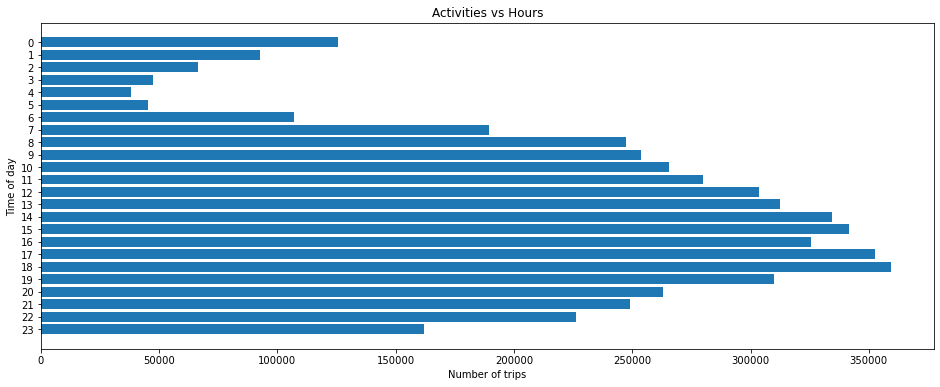

In [8]:
df_hour = df_hour.sort_values(by=['hour'])
hour_counts = np.array(df_hour['count']).astype(int)
hours = np.array(df_hour['hour'])
plt.figure(figsize=(16,6))
plt.barh(hours, hour_counts)
plt.yticks(range(0, 24))
plt.gca().invert_yaxis()
plt.xlabel("Number of trips")
plt.ylabel("Time of day")
plt.title("Activities vs Hours")
plt.show()

From the bar graph above, we can see that the busy period for taxis starts at around 6am, and goes all the way until midnight. Additionally, after midnight until 6am, there are fewer activities. So for a taxi driver the best times to drive are from 6am - 1am.

In [9]:
# save spark df using parquet
# dayOfWeek_count.write.mode("overwrite").parquet("dayOfWeek_count.parquet")
# load into pandas df
df_dayOfWeek = pq.read_pandas('dayOfWeek_count.parquet').to_pandas()

# save spark df using parquet
# month_count.write.mode("overwrite").parquet("month_count.parquet")
# load into pandas df
df_month = pq.read_pandas('month_count.parquet').to_pandas()

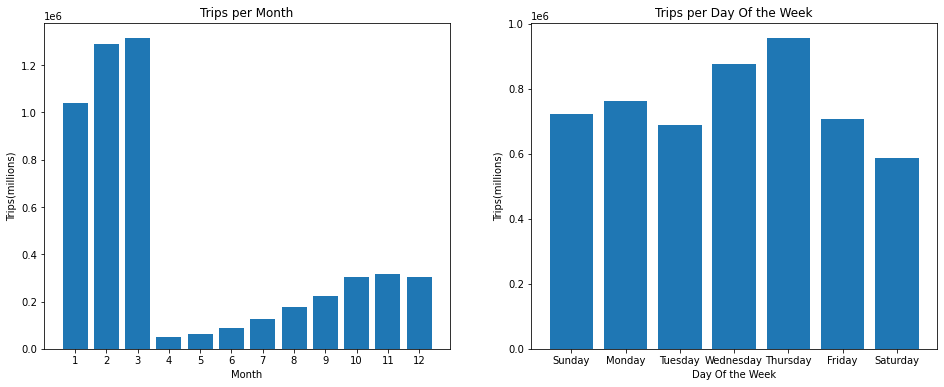

In [10]:
df_month = df_month.sort_values(by=['month'])
month_counts = np.array(df_month['count']).astype(int)
months = np.array(df_month['month'])

df_dayOfWeek = df_dayOfWeek.sort_values(by=['weekOfDay'])
dow_counts = np.array(df_dayOfWeek['count']).astype(int)
# weekOfDay 1=Sunday, 2=Monday...
dow = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

fig, axes = plt.subplots(1,2, figsize=(16,6))
axes[0].bar(months, month_counts)
axes[0].set_xticks(range(1, 13))
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Trips(millions)")
axes[0].set_title("Trips per Month")

axes[1].bar(dow, dow_counts)
axes[1].set_xlabel("Day Of the Week")
axes[1].set_ylabel("Trips(millions)")
axes[1].set_title("Trips per Day Of the Week")
plt.show()

From the Activities vs Month graph on the left, we can see that there is significantly more activity from January to March. However, starting from April, taxi activity dropped by a lot. We can assume that the reason for this is due to the pandemic.

From the Activities vs Day of Week graph, we can know the most busy day is Thursday, and Saturday has the least activities which make sense since Saturday is the first day of the weekend, and most people like to stay at home to have a rest on Saturday.


### Trip Duration
One thing that we wanted to analyze is trip duration (drop off time - pick up time). Trip duration is important because by using it, we can find the relationship between duration and amount of money a driver could make.

In [11]:
taxi_record.select(F.col('tpep_dropoff_datetime'))
recordWithDuration = taxi_record.withColumn('trip_duration',
              F.col("tpep_dropoff_datetime").cast("long") - F.col('tpep_pickup_datetime').cast("long"))
recordWithDuration = recordWithDuration.select(F.hour('tpep_pickup_datetime').alias('pickup_hour'),
                                               F.col('trip_duration'))
tripDurationVSPickupTime = (recordWithDuration.groupby('pickup_hour')
                               .agg(F.avg('trip_duration').alias('avg_trip_duration'))
                               .sort(F.col('pickup_hour')))

# save spark df using parquet
# tripDurationVSPickupTime.write.mode("overwrite").parquet("tripDurationVSPickupTime.parquet")
# load into pandas df
df_tripDurationVSPickupTime = pq.read_pandas('tripDurationVSPickupTime.parquet').to_pandas()

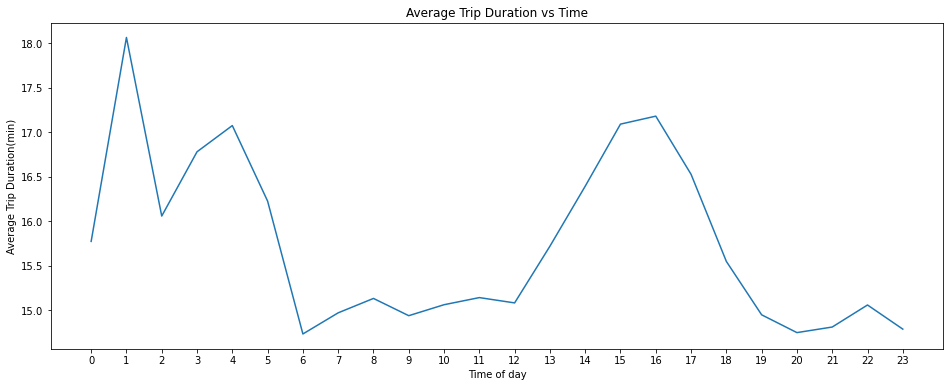

In [12]:
trip_durations = np.array(df_tripDurationVSPickupTime['avg_trip_duration'])/60
hours = np.array(df_tripDurationVSPickupTime['pickup_hour'])
plt.figure(figsize=(16,6))
plt.plot(hours, trip_durations)
plt.xticks(range(0, 24))
plt.xlabel("Time of day")
plt.ylabel("Average Trip Duration(min)")
plt.title("Average Trip Duration vs Time")
plt.show()

The figure above shows the trip duration at a given time. From the data, trip duration is higher from 1am to 4am. From 6am to Noon the trip duration is much lower. And at Noon trip duration increases until 5pm. After 5pm, the trip duration drops until midnight.

In [16]:
taxi_record.show(10)


+--------------------+---------------------+-------------+------------+------------+-----------+-----+----------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|PULocationID|DOLocationID|fare_amount|extra|tip_amount|total_amount|
+--------------------+---------------------+-------------+------------+------------+-----------+-----+----------+------------+
| 2020-01-01 00:28:15|  2020-01-01 00:33:03|          1.2|         238|         239|        6.0|  3.0|      1.47|       11.27|
| 2020-01-01 00:35:39|  2020-01-01 00:43:04|          1.2|         239|         238|        7.0|  3.0|       1.5|        12.3|
| 2020-01-01 00:47:41|  2020-01-01 00:53:52|          0.6|         238|         238|        6.0|  3.0|       1.0|        10.8|
| 2020-01-01 00:55:23|  2020-01-01 01:00:14|          0.8|         238|         151|        5.5|  0.5|      1.36|        8.16|
| 2020-01-01 00:01:58|  2020-01-01 00:04:16|          0.0|         193|         193|        3.5|  0.5|       0.

### Location
We also want to know which areas are the best locations to drive (for profit). So we have the heat map to show the number of taxi activity in the NewYork city areas. Darker red indicates more activity, and lighter red indicates less activity.

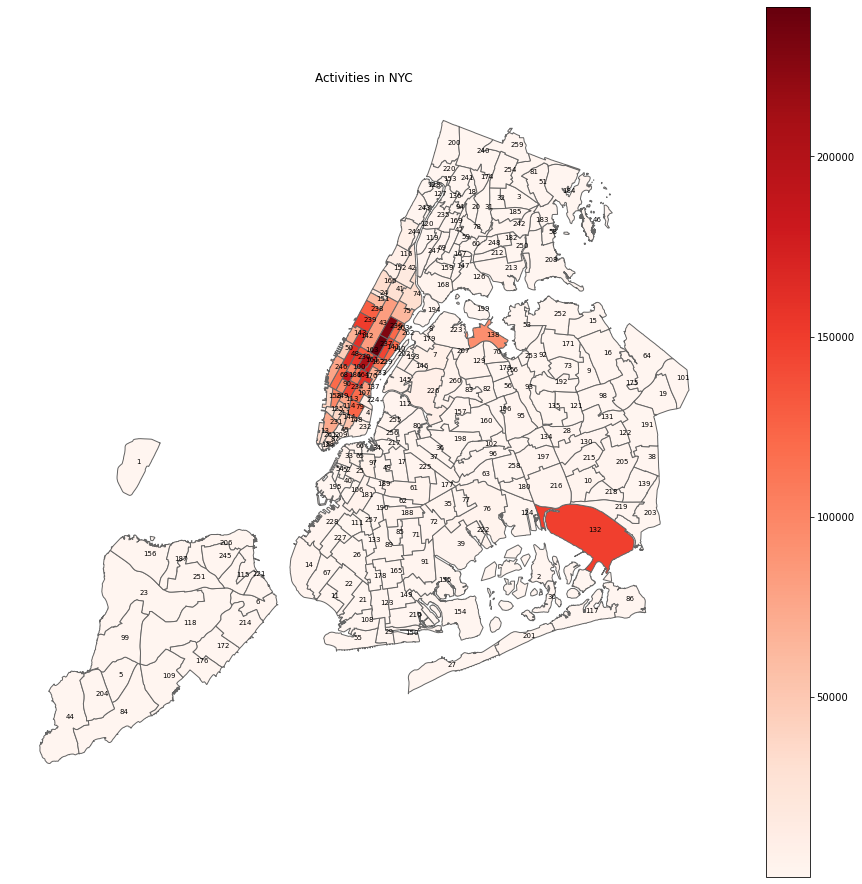

In [13]:
location_count = (taxi_record.select(F.col('PULocationID')).groupby('PULocationID').count())

# save spark df using parquet
# location_count.write.mode("overwrite").parquet("location_count.parquet")
# load into pandas df
df_location_count = pq.read_pandas('location_count.parquet').to_pandas()

df_location_count = df_location_count.rename(columns={"PULocationID": "LocationID"})
nyc_map = gpd.read_file("data/taxi_zones/taxi_zones.shp")
map_and_stats=nyc_map.merge(df_location_count, on="LocationID")

# Plot
fig, ax = plt.subplots(1, figsize=(16, 16))
map_and_stats.plot(column="count", cmap="Reds", linewidth=1, ax=ax, edgecolor=".4")
plt.title('Activities in NYC')
map_and_stats["center"] = map_and_stats["geometry"].centroid
map_points = map_and_stats.copy()
map_points.set_geometry("center", inplace = True)
texts = []

for x, y, locationID in zip(map_points.geometry.x, map_points.geometry.y, map_points["LocationID"]):
    texts.append(plt.text(x, y, locationID, fontsize = 7))

count = np.array(map_and_stats['count'])
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=count.min(), vmax=count.max()))
bar_info._A = []
plt.axis('off')
cbar = fig.colorbar(bar_info)

From the heat map above, we can see that most taxi activities are in Manhattan area.

In [14]:
first_15_area = df_location_count.sort_values(by=['count'], ascending=False)[:15]
locationIDs_arr = np.array(first_15_area['LocationID'])
counts_arr = np.array(first_15_area['count'])
print('Rank of Activities in NYC:(first 15)\n')
for area, count in zip(locationIDs_arr, counts_arr):
    borough = location_df[location_df['LocationID'] == area]['Borough'].values[0]
    zone = location_df[location_df['LocationID'] == area]['Zone'].values[0]
    print(f'{borough} {zone} : {count}')

Rank of Activities in NYC:(first 15)

Manhattan Upper East Side South : 241495
Manhattan Upper East Side North : 228417
Manhattan Midtown Center : 204748
Manhattan Penn Station/Madison Sq West : 185844
Manhattan Midtown East : 176905
Manhattan Lincoln Square East : 160647
Manhattan Murray Hill : 159914
Manhattan Clinton East : 159587
Manhattan Times Sq/Theatre District : 153528
Manhattan Upper West Side South : 150861
Queens JFK Airport : 148936
Manhattan Union Sq : 145125
Manhattan Lenox Hill West : 144405
Manhattan Midtown North : 131420
Manhattan Upper West Side North : 126945


### Profit
<!-- For taxi drivers, of course the most important thing is money. We want to know the relation of fareamount and pickup location, and the relation of money and pickup time (tips/time, total_fare/time, extras/time). In addition, we also want to know whether short trips that cover a long distance or long one where one is tuck in traffic are more profitable. 
 -->

For taxi drivers, the most important thing is money. We want to know the relation between fare_amount and pickup location since some areas might inherently offer more money because of distance or heavy traffic. We also would like to know about the relationship between fare_amount and pickup time since above we saw that pickup time can influence trip duration. Other metrics we are looking at are (tips/time, total_fare/time, extras/time). In addition, we would like to know which would net a higher profit: short trips that cover a long distance, or a long trip that covers a short distance (could be stuck in traffic)


#### Total Amount vs Location

In [15]:
# Profit vs location
money_location = taxi_record.select(F.col('total_amount'), F.col('PULocationID').alias('LocationID'))
moneyVSLocation = (money_location.groupby('LocationID')
                  .agg(F.avg("total_amount").alias('total_amount')))

# save spark df using parquet
# moneyVSLocation.write.mode("overwrite").parquet("moneyVSLocation.parquet")
# load into pandas df
df_moneyVSLocation = pq.read_pandas('moneyVSLocation.parquet').to_pandas()

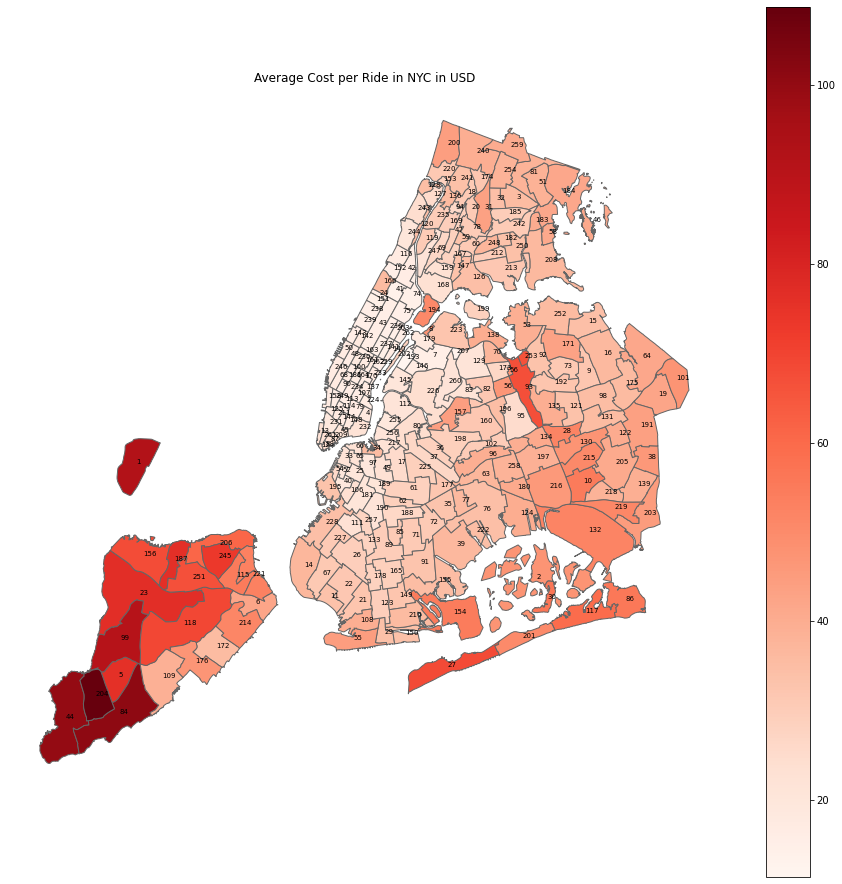

In [16]:
map_and_stats=nyc_map.merge(df_moneyVSLocation, on="LocationID")
fig, ax = plt.subplots(1, figsize=(16, 16))
plt.title('Average Cost per Ride in NYC in USD')
map_and_stats.plot(column="total_amount", cmap="Reds", linewidth=1, ax=ax, edgecolor=".4")

map_and_stats["center"] = map_and_stats["geometry"].centroid
map_points = map_and_stats.copy()
map_points.set_geometry("center", inplace = True)
texts = []

for x, y, locationID in zip(map_points.geometry.x, map_points.geometry.y, map_points["LocationID"]):
    texts.append(plt.text(x, y, locationID, fontsize = 7))

price = np.array(map_and_stats['total_amount'])
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=price.min(), vmax=price.max()))
bar_info._A = []
plt.axis('off')
cbar = fig.colorbar(bar_info)

From the Average Cost per ride in NYC heat map above, we can see that if a taxi picks up someone from Staten Island Borough, drivers may earn more money.

In [17]:
first_5_area = df_moneyVSLocation.sort_values(by=['total_amount'], ascending=False)[:5]
locationIDs_arr = np.array(first_5_area['LocationID'])
counts_arr = np.array(first_5_area['total_amount'])
print('Rank of Activities in NYC:(first 5)\n')
for area, count in zip(locationIDs_arr, counts_arr):
    borough = location_df[location_df['LocationID'] == area]['Borough'].values[0]
    zone = location_df[location_df['LocationID'] == area]['Zone'].values[0]
    print(f'{borough} {zone} : {(count.round(2))}')

Rank of Activities in NYC:(first 5)

Staten Island Rossville/Woodrow : 108.74
Staten Island Eltingville/Annadale/Prince's Bay : 101.07
Staten Island Charleston/Tottenville : 99.83
EWR Newark Airport : 92.21
Staten Island Freshkills Park : 91.17


#### Money vs Hour
Money including fare amount, extra and tips. We want to see if any of these factors are affected by the different time periods.

In [18]:
recordWithDuration = taxi_record.withColumn('trip_duration',
              F.col("tpep_dropoff_datetime").cast("long") - F.col('tpep_pickup_datetime').cast("long"))
money_time = recordWithDuration.select(F.col('fare_amount')
                                       , F.col('extra').cast('long')
                                       , F.col('tip_amount')
                                       , F.hour('tpep_pickup_datetime').alias('hour'))
moneyVSTime = (money_time.groupby('hour')
                  .agg(F.avg("extra").alias('avg_extra'),
                       F.avg('tip_amount').alias('avg_tip_amount'),
                       F.avg('fare_amount').alias('avg_fare_amount'))
                  .sort(F.col('hour')))

# save spark df using parquet
# moneyVSTime.write.mode("overwrite").parquet("moneyVSTime.parquet")
# load into pandas df
df_moneyVSTime = pq.read_pandas('moneyVSTime.parquet').to_pandas()

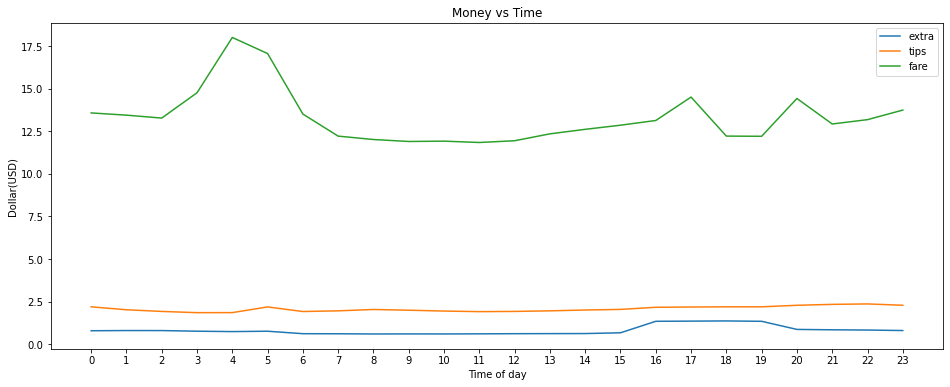

In [19]:
avg_extra = np.array(df_moneyVSTime['avg_extra'])
avg_tip = np.array(df_moneyVSTime['avg_tip_amount'])
avg_fare = np.array(df_moneyVSTime['avg_fare_amount'])
hours = np.array(df_moneyVSTime['hour'])
plt.figure(figsize=(16,6))
plt.plot(hours, avg_extra, label='extra')
plt.plot(hours, avg_tip, label='tips')
plt.plot(hours, avg_fare, label='fare')
plt.xticks(range(0, 24))
plt.xlabel("Time of day")
plt.ylabel("Dollar(USD)")
plt.title("Money vs Time")
plt.legend()
plt.show()

From the Money vs Time graph, we can see that tips and extra are very close to each other in different time, average tips are around \\$2.5, and average extra are around \\$1. However, for fare amount, if you pickup passangers at 4am, 5am, 5pm, and 8pm, you may earn more money.

#### Fare Amount vs Distance and Time Duration

In [20]:
dist_time_price = recordWithDuration.select(F.col('trip_distance'), F.col('trip_duration'), F.col('fare_amount'))

# # save spark df
# dist_time_price.write.mode("overwrite").parquet("dist_time_price.parquet")
# # load into pandas df
dist_time_price_df = pq.read_pandas('dist_time_price.parquet').to_pandas()

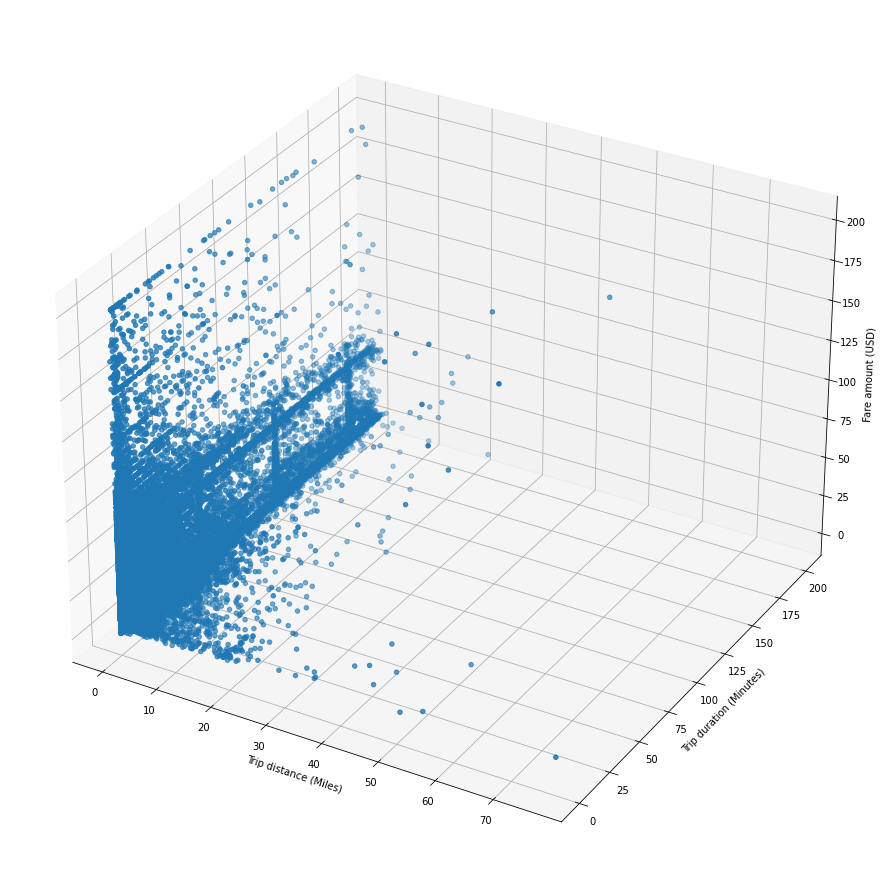

In [21]:
dist_time_price_df[dist_time_price_df < 0] = None
# there are a little extremely high number records which not help visualization
dist_time_price_df[dist_time_price_df > 200] = None
dist_time_price_df = dist_time_price_df.dropna()
X = np.array(dist_time_price_df['trip_distance'])
Y = np.array(dist_time_price_df['trip_duration'])
Z = np.array(dist_time_price_df['fare_amount'])

fig = plt.figure(figsize=(16, 16))
# Create 3D container
ax = plt.axes(projection = '3d')
# Visualize 3D scatter plot
ax.scatter3D(X, Y, Z)
# Give labels
ax.set_xlabel('Trip distance (Miles)')
ax.set_ylabel('Trip duration (Minutes)')
ax.set_zlabel('Fare amount (USD)')
plt.show();

The 3d graph above shows Fare amount vs (trip distance and trip duration).

We can see that distance, and duration does not have a significant effect on the fare amount. Although there isn't a significant effect, the graph does show that there must be a base fee after a specific period of time, because there are lines hovering around $50. We saw a large amount of discrepancies where the distance/duration were 0 and would cost a large amount of money. This skews the visualization making a lot of data points stacked up on each other.

A reason for this might be that NYC taxi’s have an E-Hail program that allows users to pay for a trip online without the meter being on. This could explain the large number of 0 distance records. For the 0 time records, we couldn’t find a logical explanation.



## Distance & Amount

In the figure above we can see that as distance increases there is a small line indicating that up until 20 miles there is a trend showing that the amount will be greater. Otherwise, the data shows that there is a base rate. This outlier could represent time since it takes longer to travel a longer distance.

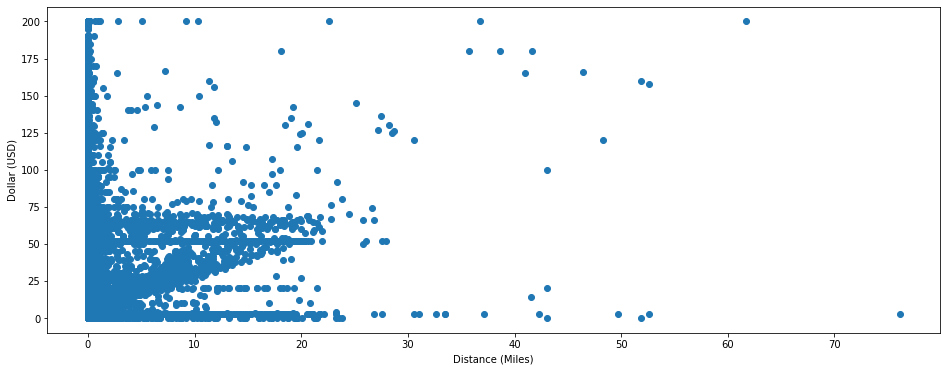

In [29]:
dist_time_price
distance = np.array(dist_time_price_df['trip_distance'])
duration = np.array(dist_time_price_df['trip_duration'])
amount = np.array(dist_time_price_df['fare_amount'])
plt.figure(figsize=(16,6))
plt.xlabel('Distance (Miles)')
plt.ylabel('Dollar (USD)')
plt.scatter(distance, amount)
plt.show()

## Duration & Distance

As duration increases, there is a trend going down from the amount. There is a flat line at $50 indicating that there must be a base rate after a specific time. 

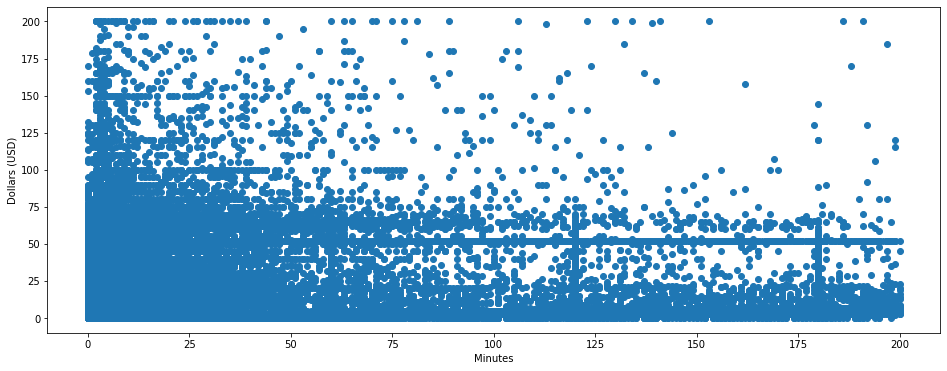

In [22]:
dist_time_price
distance = np.array(dist_time_price_df['trip_distance'])
duration = np.array(dist_time_price_df['trip_duration'])
amount = np.array(dist_time_price_df['fare_amount'])
plt.figure(figsize=(16,6))
plt.xlabel('Minutes')
plt.ylabel('Dollars (USD)')
plt.scatter(duration, amount)

## Machine Learning
We can use Machine Learning to help taxi drivers predict fare amounts for the next trip. In real life, taxi passengers always like to ask the price right after stating the destination location. Many drivers with experience can quickly respond with a rough price. And the model can look through the 5 million records to become an experienced taxi driver and make a prediction of the fare amount based on pickup location and drop off location.

We use supervised Neural network models: multi-layer perceptron regression model (MLPRegressor). MLPRegressor trains using backpropagation with no activation function in the output layer, which can also be seen as using the identity function as activation function. Therefore, it uses the square error as the loss function, and the output is a set of continuous values.


In [33]:
# data process in spark
loc_price = taxi_record.select(F.col("PULocationID").alias("PU"),
                   F.col("DOLocationID").alias("DO"),
                   F.col("fare_amount").alias("Price"))
# filter null value record and unknown record(locationID: 264 and 265 are unknown)
loc_price = loc_price.filter(loc_price.PU.isNotNull() & loc_price.PU.between(1, 263)
                             & loc_price.DO.isNotNull() & loc_price.DO.between(1, 263)
                             & loc_price.Price.isNotNull())

In [34]:
# convert spark df to pandas df using parquet. Uncomment next line if need reload

# loc_price.write.mode("overwrite").parquet("loc_price.parquet")

# load into pandas df
pd_df = pq.read_pandas('loc_price.parquet').to_pandas()

In [35]:
# data process in pandas df
pickup = np.array(pd_df.PU).astype(float)
dropoff = np.array(pd_df.DO).astype(float)

location = np.vstack((pickup, dropoff)).T
price = np.array(pd_df.Price).astype(float)
# data split
X_train, X_test, y_train, y_test = train_test_split(location, price, test_size=0.2)

##### Training model may takes 4 min, we also save the model as a file `trained_model.sav`. Therefore we can skip this cell and just run next cell to load the saved model.

In [32]:
# %%time
# # train the model
# regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

# # save model to disk
# filename = 'trained_model.sav'
# joblib.dump(regr, filename)

In [36]:
filename = 'trained_model.sav'
trained_model = joblib.load(filename)
y_pred = trained_model.predict(X_test)

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator MLPRegressor from version 1.0 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [37]:
def cal_accuracy(pred, actual):
    count = 0;
    for i in range(len(actual)):
        if (abs(pred[i] - actual[i]) <= 7):
            count = count + 1
    accuracy = count/len(actual)
    return accuracy
print("price accuracy(accept +- 7 error) : %.2f" %cal_accuracy(y_pred, y_test))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

price accuracy(accept +- 7 error) : 0.72
Coefficient of determination: 0.07
Mean squared error: 111.16


In [38]:
def on_button_clicked(b):
    with output:
        output.clear_output()
        price = trained_model.predict([[d1.value, d2.value]])
        price_format = "{:.5f}".format(price[0])
        print(f"Predict Price = ${price_format}")
# dropdown options list
loc_df = pd.read_csv("data/taxi+_zone_lookup.csv")
loc_dict = dict(zip(loc_df.LocationID, loc_df.Borough + " " + loc_df.Zone))
loc_options = []
for key, value in loc_dict.items():
    loc_options.append((value, key))
# remove two element unknown and nan
_ = loc_options.pop()
_ = loc_options.pop()        

d1 = widgets.Dropdown(
    options=loc_options,
    value=1,
    description='From:',
)
d2 = widgets.Dropdown(
    options=loc_options,
    value=1,
    description='To:',
)
button = widgets.Button(description="Calculate")
button.on_click(on_button_clicked)

output = widgets.Output()

items = [d1, d2, button, output]
box = widgets.Box(children=items)
display(box)

Box(children=(Dropdown(description='From:', options=(('EWR Newark Airport', 1), ('Queens Jamaica Bay', 2), ('B…

### Results

If we were to accept an error margin of 7$, our accuracy would be around 72% which is not the best. There were a lot of outliers we could not account for like the E-Hail program, which threw some numbers off with a 0 travel distance but still had a fare. There were also some entries that had 0 travel distance and 0 time duration but still had a fare. This skews the machine learning algorithm, resulting in a lower accuracy rating. Our mean squared error is over 110, so our regression line is far from our set of data points. Overall, our machine learning algorithm is decent at best and would need more time and accurate data to be better.